<a href="https://colab.research.google.com/github/llffhh/Stock-Prediction-by-CNN-Study/blob/develop/stock_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install tensorflow_addons
import tensorflow as tf
import numpy as np
import requests
import datetime
import json
import re
import pandas as pd
%matplotlib inline
import torch

     |████████████████████████████████| 706kB 8.6MB/s 


In [ ]:
import numpy as np
import requests
import datetime
import json
import re
import pandas as pd

# https://finance.yahoo.com/quote/2330.TW/history?period1=946944000&period2=1602633600&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true'
# https://query1.finance.yahoo.com/v7/finance/download/2330.TW?period1=0&period2=1549258857&interval=1d&events=history&crumb=hP2rOschxO0
class StockCrawl():
  # set a default parameter
  def __init__(self,name):
    self.name = name+'.TW'
    self.url = 'https://finance.yahoo.com/quote/'
    self.start = '/history?period1='
    self.startdate = str(int(datetime.datetime(2000,1,1).timestamp()))
    self.end = '&period2='
    self.enddate = str(int(datetime.datetime.now().timestamp()))
    self.endhttps = '&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true'
    self.headers = {'User-Agent':'Mozilla/5.0,Chrome/85.0.4183.102'} #Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/85.0.4183.102 Safari/537.36 Edg/85.0.564.51

  # set a date period
  def period(self, startdate = None):
    if startdate == None:
      startdate_re = self.startdate
    else:
      A = startdate.split('-',2)
      startdate_re = str(int(datetime.datetime(int(A[0]),int(A[1]),int(A[2])).timestamp()))

    url = self.url + self.name + self.start + startdate_re + self.end + self.enddate + self.endhttps
    dfv = self.loadpage(url)
    return dfv

  # load page
  def loadpage(self,url):
    req = requests.get(url,headers = self.headers)
    dfv = self.parsepage(req)
    return dfv

  # parse page
  def parsepage(self,req):
    pattern = re.compile(r"\"HistoricalPriceStore\":(.*?),\"isPending\"")
    jsonReqTest = pattern.findall(req.text)
    jsonReqStr = str(jsonReqTest[0]+'}')
    patternDate = re.compile(r"{\"date\":(.*?),")
    patternOpen = re.compile(r"\"open\":(.*?),")
    patternHigh = re.compile(r"\"high\":(.*?),")
    patternLow = re.compile(r"\"low\":(.*?),")
    patternClose = re.compile(r"\"close\":(.*?),")
    patternVolume = re.compile(r"\"volume\":(.*?),")
    patternAdjclose = re.compile(r"\"adjclose\":(.*?)}")

    dataDate = patternDate.findall(jsonReqStr)
    dataOpen = patternOpen.findall(jsonReqStr)
    dataHigh = patternHigh.findall(jsonReqStr)
    dataLow = patternLow.findall(jsonReqStr)
    dataClose = patternClose.findall(jsonReqStr)
    dataVolume = patternVolume.findall(jsonReqStr)
    dataAdjclose = patternAdjclose.findall(jsonReqStr)

    class dataDateformat():
      def __init__(self):
        self.dataDate_re=[]
        self.dataDateArr=[]
      def Dateformat(self,datalist):
        for i in range(len(datalist)):
          if i == 0:
            self.dataDateArr.append(datalist[i])
          else:
            if datalist[i] == datalist[i-1]:
              pass
            else:
              self.dataDateArr.append(datalist[i])
        for i in self.dataDateArr:
          date_or = datetime.datetime.fromtimestamp(int(i))
          date_re = date_or.strftime("%b. %d, %Y")
          self.dataDate_re.append(date_re)
        return self.dataDate_re

    class datafloat():
      def __init__(self):
        self.datafloat_re=[]
      def floating(self,datalist):
        for i in datalist:
          if i == "null":
            self.datafloat_re.append(np.NaN)
          else:
            self.datafloat_re.append(round(float(i),2))
        return self.datafloat_re

    dataDate_re = dataDateformat().Dateformat(dataDate)
    dataOpen_re = datafloat().floating(dataOpen)
    dataHigh_re = datafloat().floating(dataHigh)
    dataLow_re = datafloat().floating(dataLow)
    dataClose_re = datafloat().floating(dataClose)
    dataAdjclose_re = datafloat().floating(dataAdjclose)
    dataVolume_re = datafloat().floating(dataVolume)
    #dataVolumenew_re = list(map(lambda dataVolumenew_re : [int(dataVolume_re[i]) for i in range(len(dataVolume_re))], dataVolume_re))[0]

    dataStock={'Date':dataDate_re,'open':dataOpen_re,'high':dataHigh_re,'low':dataLow_re,'close':dataClose_re,'Adj Close':dataAdjclose_re,
               'volume':dataVolume_re}
    dfv = self.writepage(dataStock)
    return dfv

  # write page
  def writepage(self,dataStock):
    df = pd.DataFrame.from_dict(dataStock)
    df = df.sort_index(ascending = False)
    df = df.set_index('Date')
    df.index = pd.DatetimeIndex(df.index)
    dfdn = df.interpolate(method='ffill')
    dfv = dfdn.convert_dtypes()
    dfv.to_csv('/content/drive/MyDrive/'+self.name+'.csv')
    print(dfv)
    return dfv


In [ ]:
#@title
import numpy as np
class TechIndicator():
  def __init__(self):
    pass
  
  def WilderSmooth(self,data,day):
    tday = day-1
    AveWSGain = np.zeros(len(data))
    AveWSLoss = np.zeros(len(data))
    Gain = np.zeros(len(data))
    Loss = np.zeros(len(data))
    for i in range(len(data)-1):
      if data.close[i+1]>=data.close[i]:
        Gain[i+1] = data.close[i+1]-data.close[i]
      else:
        Loss[i+1] = data.close[i+1]-data.close[i]
    for i in range(len(data)-tday):
      if i == 0:
        AveWSGain[tday+i] = np.average(Gain[i:tday+1])
        AveWSLoss[tday+i] = np.average(Loss[i:tday+1])
      else:
        AveWSGain[tday+i] = AveWSGain[tday+i-1]+(Gain[tday+i]-AveWSGain[tday+i-1])/(tday+1)
        AveWSLoss[tday+i] = AveWSLoss[tday+i-1]+(Loss[tday+i]-AveWSLoss[tday+i-1])/(tday+1)
    return AveWSGain, AveWSLoss, Gain, Loss


  def RSI(self,data,day):
    #rsi = np.zeros(len(data))
    rsi = np.full(len(data),np.nan)
    AveWSGain,AveWSLoss, Gain, Loss = self.WilderSmooth(data,day)
    RS = AveWSGain/np.abs(AveWSLoss)
    rsi = 100*(RS/(1+RS))
    return rsi
    

  def WilliamR(self,data,day):
    tday = day-1
    #WR = np.zeros(len(data))
    WR = np.full(len(data),np.nan)
    for i in range(len(data)-tday):
      WR[tday+i] = ((np.max(data.high[i:tday+i+1])-data.close[tday+i])
      /(np.max(data.high[i:tday+i+1])-np.min(data.low[i:tday+i+1])))*(-100)
    return WR
  
  def MA(self,data,day):
    tday = day-1
    #MAt = np.zeros(len(data))
    MAt = np.full(len(data),np.nan)
    for i in range(len(data)-tday):
      MAt[tday+i] = np.average(data.close[i:tday+i+1])
    return MAt

  def EMA(self,data,day):  
    tday = day - 1
    EMAt = np.zeros(len(data))
    #EMAt = np.full(len(data),np.nan)
    for i in range(len(data)-tday):
      if i == 0:
        EMAt[tday+i] = np.average(data.close[i:tday+i+1])
      else:
        EMAt[tday+i] = EMAt[tday+i-1]+2/(tday+1+1)*(data.close[tday+i]-EMAt[tday+i-1])
    #EMAt[0:tday] = np.nan
    return EMAt
  
  def WMA(self,data,day):
    tday = day - 1
    #WMAt = np.zeros(len(data))
    WMAt = np.full(len(data),np.nan)
    Wn = np.array(list(range(1,tday+2)))
    for i in range(len(data)-tday):     
      WMAt[tday+i] = np.average(np.array(data.close[i:tday+i+1]),weights=Wn) 
    return WMAt

  def HMA(self,data,day):
    #HMAt = np.zeros(len(data))
    HMAt = np.full(len(data),np.nan)
    #產生由完整時間區域所產生的HMA
    HMA_f = self.WMA(data,day)
    #產生由一半的時間區域所產生的HMA
    tday = int(np.ceil(day/2))+1
    HMA_h = self.WMA(data,tday)
    HMA_hf = 2*HMA_h - HMA_f
    tday = int(np.ceil(np.sqrt(day)))+1
    data = pd.DataFrame.from_dict({'close':HMA_hf})
    HMAt = self.WMA(data,tday)
    return HMAt
  
  def TEMA(self,data,day):
    #first time of EMA
    EMAt=self.EMA(data,day)
    data=pd.DataFrame.from_dict({'close':EMAt})
    #second time of EMA
    EMAtt=self.EMA(data,day)
    data=pd.DataFrame.from_dict({'close':EMAtt})
    #third time of EMA
    EMAttt=self.EMA(data,day)
    TEMA = 3*EMAt-3*EMAtt+EMAttt
    #TEMA[0:day]=0
    TEMA[0:(day-1)*3]=[np.nan]
    return TEMA

  def CCI(self,data,day):
    '''
    TP = (close + high + low)/3
    MA = 20 period SMA of TP 
    CCI = (TP-MA)/(0.015*mean deviation)
    '''
    tday = day-1
    TP = (data.close+data.high+data.low)/3
    MA = np.zeros(len(data))
    #MA = np.full(len(data),np.nan)
    MD = np.zeros(len(data))
    #MD = np.full(len(data),np.nan)
    for i in range(len(TP)-tday):
      MDt = [] # initialize the Mean Deviation
      MAt = np.average(TP[i:day+i])
      for j in range(day):
        MDt.append(abs(TP[i+j]-MAt))
      MD[tday+i] = np.average(MDt)
      MA[tday+i] = MAt
    CCI = (TP-MA)/(0.015*MD)
    
    CCI[0:tday]=np.nan
    # print(len(CCI))
    return CCI
  
  def CMO(self,data,day):
    tday = day - 1
    AveWSGain,AveWSLoss, Gain, Loss = self.WilderSmooth(data,day)
    #CMOt = np.zeros(len(data))
    CMOt = np.full(len(data),np.nan)
    for i in range(len(data)-tday):
      CMOt[tday+i] = (np.sum(Gain[i:day+i])-abs(np.sum(Loss[i:day+i])))/(np.sum(Gain[i:day+i])+abs(np.sum(Loss[i:day+i])))*100
    return CMOt

  def MACD(self,data,day):
    EMA12 = self.EMA(data,12)
    EMA26 = self.EMA(data,26)
    EMA12[0:25] = [0]
    MACD = EMA12 - EMA26
    signalLine = self.EMA(pd.DataFrame.from_dict({'close':MACD}),9)
    MACDhist = MACD-signalLine
    MACDhist[0:33] = [np.nan]
    return MACD,signalLine,MACDhist
  
  def PPO(self,data,day): #論文用MA
    PPO = (self.MA(data,12)-self.MA(data,26))/self.MA(data,26)*100
    signalLine = self.EMA(pd.DataFrame.from_dict({'close':PPO}),9)
    return PPO
  
  def ROC(self,data,day): 
    tday = day - 1
    #ROC = np.zeros(len(data))
    ROC = np.full(len(data),np.nan)
    for i in range(len(data)-tday):
      ROC[tday+i] = (data.close[i+tday]-data.close[i])/data.close[i]*100
    return ROC

  def CMFI(self,data,day):    # 12 period
    tday = 12 - 1
    Multiplier = ((data.close-data.low)-(data.high-data.close))/(data.high-data.low)
    MFV = data.volume*Multiplier  # Money Flow Volume
    #CMFI = np.zeros(len(data))
    CMFI = np.full(len(data),np.nan)
    for i in range(len(data)-tday):
      CMFI[tday+i] = np.sum(Multiplier[i:tday+i+1])/np.sum(MFV[i:tday+i+1])
    return CMFI  
  
  def DMI(self,data,day):  # still got some problem
    tday = day - 1
    UpMove = np.zeros(len(data))
    DownMove = np.zeros(len(data))
    posDMI = np.zeros(len(data))
    negDMI = np.zeros(len(data))
    TR = np.zeros(len(data))
    #TR = np.full(len(data),np.nan)
    tt = 1
    for i in range(len(data)-tt):
      UpMove[tt+i] = data.high[i+tt] - data.high[i]
      DownMove[tt+i] = data.low[i] - data.low[i+tt]
      if UpMove[tt+i]>DownMove[tt+i] and UpMove[tt+i]>0:
        posDMI[tt+i] = UpMove[tt+i]
      else:
        posDMI[tt+i] = 0

      if DownMove[tt+i]>UpMove[tt+i] and DownMove[tt+i]>0:
        negDMI[tt+i] = DownMove[tt+i]
      else:
        negDMI[tt+i] = 0

      if posDMI[tt+i]>negDMI[tt+1]:
        negDMI[tt+i] = 0
      else:
        posDMI[tt+i] = 0
      TRprice = [data.high[tt+i]-data.low[tt+i], data.high[tt+i]-data.close[i], data.low[tt+i]-data.close[i]]
      TR[tt+i] = np.max(np.abs(TRprice))
      
    posDI = 100*self.EMA(pd.DataFrame.from_dict({'close':posDMI}),day)/self.EMA(pd.DataFrame.from_dict({'close':TR}),day)
    negDI = 100*self.EMA(pd.DataFrame.from_dict({'close':negDMI}),day)/self.EMA(pd.DataFrame.from_dict({'close':TR}),day)
    DX = abs((posDI-negDI)/(posDI+negDI))*100
    DX[0:tday] = 0
    ADX = self.EMA(pd.DataFrame.from_dict({'close':DX}),day)
    ADX[0:tday] = np.nan
    return posDI,negDI,ADX,DX,posDMI,negDMI

  def SAR(self,data,day):
    def RPSAR(PSAR,AF,EP):
      RPSAR = PSAR + AF*(EP-PSAR)
      return RPSAR
    def FPSAR(PSAR,AF,EP):
      FPSAR = PSAR - AF*(PSAR-EP)
      return FPSAR
      
    [AF,AF_max] = [0.02,0.2]
    #SAR = np.zeros(len(data))
    SAR = np.full(len(data),np.nan)
    period = 5
    tt = period - 1
    for i in range(len(data)-tt):
      if i == 0:
        if dataStock.close[i+tt]>dataStock.close[i]: #uptrend
          PSAR = np.min(dataStock.low[i:i+period])
          EP = np.max(dataStock.high[i:i+period])
        else:
          PSAR = np.max(dataStock.high[i:i+period])
          EP = np.min(dataStock.low[i:i+period])
      else:
        if dataStock.close[i+tt]>PSAR:       #uptrend
          PSAR = RPSAR(PSAR,AF,EP)
          if dataStock.close[i+tt-1]<PSAR:
            AF = 0.02
          if dataStock.high[i+tt]>EP:
            if AF >= AF_max:
              AF = 0.2
            else:
              AF += 0.04
            EP = dataStock.high[i+tt]
        else:                               #downtrend
          PSAR = FPSAR(PSAR,AF,EP)
          if dataStock.close[i+tt-1]>PSAR:
            AF = 0.02
          if dataStock.low[i+tt]<EP:
            if AF >= AF_max:
              AF = 0.2
            else:
              AF += 0.04
            EP = dataStock.low[i+tt]
      SAR[i+tt] = PSAR
    return SAR

In [ ]:
import numpy as np
import math

# -1 sell; 0 hold; 1 buy
class triple_barrier():
  '''
  example:
  ret = triple_barrier.triple_barrier(dataStock.close, 1.1, 0.95, 10)
  StockTechRet=pd.concat([StockTech,ret],axis=1)
  '''
  def __init__(self):
    pass

  def triple_barrier(data, ub, lb, max_period):

      price = data.close

      def end_price(s):
          return np.append(s[(s / s[0] > ub) | (s / s[0] < lb)], s[-1])[0]/s[0]
      
      r = np.array(range(max_period))
      
      def end_time(s):
          return np.append(r[(s / s[0] > ub) | (s / s[0] < lb)], max_period-1)[0]

      p = price.rolling(max_period).apply(end_price, raw=True).shift(-max_period+1)
      

      
      t = price.rolling(max_period).apply(end_time, raw=True).shift(-max_period+1)
      t = pd.Series([t.index[int(k+i)] if not math.isnan(k+i) else np.datetime64('NaT') 
                    for i, k in enumerate(t)], index=t.index).dropna()

      signal = pd.Series(0, p.index)
      signal.loc[p > ub] = 1
      signal.loc[p < lb] = -1
      
      # ret = pd.DataFrame(dataStock.index)
      ret = pd.DataFrame(data.index)
      ret = ret.set_index('Date')
      ret['triple_barrier_profir'] = p
      ret['triple_barrier_sell_time'] = t
      ret['triple_barrier_signal'] = signal
      ret['triple_barrier_close'] = data.close

      return ret



In [ ]:
class FinancialTesting():
  '''
  FinancialTesting(data, period, cash, eachStock, triple_barrier_period, passlosssignal)
  period = How long do we buy the stock
  cash = Initial Cash
  eachStock = How many stock do we buy per time
  triple_barrier_period = The period we set in triple barrier function
  passlosssignal = if 1, mean we don't buy any stock when the signal is stop loss signal
  '''
  def __init__(self, data, period, cash, eachStock, triple_barrier_period, passlosssignal):   
    self.period = period
    self.stockNumber = 0
    self.StockValue = 0
    self.Cash = cash
    self.EachTime = eachStock # 100 stock
    self.signalRecord = []
    self.CashList = []
    self.StockCost = 0
    self.StockTechRet_Nonan = data
    self.passlosssignal = passlosssignal
    self.triple_barrier_period = triple_barrier_period
    self.buying_price = []
    self.selling_price = []
    
  def buying(self, signal, stockcost_eachTime):
    # print("Buying signal is triggered ({} period), signal: {}".format(self.period, signal))
    self.Cash -= stockcost_eachTime
    self.stockNumber += self.EachTime
    self.StockCost += stockcost_eachTime
    self.signalRecord.append(signal)
    # print("Buying price: {}, Cash: {}".format(self.StockTechRet_Nonan.close[i],self.Cash))

  def sellingsignal(self, signal, stockcost_eachTime, futureTime):
    difference = self.StockTechRet_Nonan.close[futureTime]*self.EachTime-stockcost_eachTime
    self.Cash += difference + stockcost_eachTime
    self.StockCost -= self.StockTechRet_Nonan.close[i]*self.EachTime
    self.stockNumber -= self.EachTime
    return difference

  def process(self):
    for i in range(len(self.StockTechRet_Nonan)-self.triple_barrier_period):
      futureTime = self.StockTechRet_Nonan.triple_barrier_sell_time[i]
      signal = self.StockTechRet_Nonan.triple_barrier_signal[i]
      # Buy the Stock after a specific period and calculate the profit we make after specific period
      if i == 0 or (i+1)%self.period==0:
        if signal == 1: #stop profit
          stockcost_eachTime = self.StockTechRet_Nonan.close[i]*self.EachTime
          self.buying(signal, stockcost_eachTime)
          difference = self.sellingsignal(signal, stockcost_eachTime, futureTime)
          self.buying_price.append(self.StockTechRet_Nonan.close[i])
          self.selling_price.append(self.StockTechRet_Nonan.close[futureTime])
          # print('Selling price: {}, Cash: {}, Stop Profit: {}\n'.format(self.StockTechRet_Nonan.close[futureTime], self.Cash, difference))
        elif signal == -1 and self.passlosssignal == 0: #stop loss        
          stockcost_eachTime = self.StockTechRet_Nonan.close[i]*self.EachTime
          self.buying(signal, stockcost_eachTime)
          difference = self.sellingsignal(signal, stockcost_eachTime, futureTime)
          self.buying_price.append(self.StockTechRet_Nonan.close[i])
          self.selling_price.append(self.StockTechRet_Nonan.close[futureTime])
          # print('Selling price: {}, Cash: {}, Stop Loss: {}\n'.format(self.StockTechRet_Nonan.close[futureTime], self.Cash, difference))
        elif signal == 0:
          stockcost_eachTime = self.StockTechRet_Nonan.close[i]*self.EachTime
          self.buying(signal, stockcost_eachTime)
          self.buying_price.append(self.StockTechRet_Nonan.close[i])
          # difference = self.sellingsignal(signal, stockcost_eachTime, futureTime)
      # Calculate the profit\loss we make when hold signal is triggered, stock number equal to each stock
      if self.stockNumber > 0:  
        # print("Holding signal is triggered and the signal now: {}".format(signal))
        # print("Future price (holding signal): {}".format(self.StockTechRet_Nonan.close[futureTime]))
        if self.StockTechRet_Nonan.triple_barrier_signal[i] == 1:
          stockcost_eachTime = self.StockCost/self.stockNumber*self.EachTime
          difference = self.sellingsignal(signal, stockcost_eachTime, futureTime)
          self.selling_price.append(self.StockTechRet_Nonan.close[futureTime])
          # print('Selling price: {}, Cash: {}, Stop Profit: {}\n'.format(self.StockTechRet_Nonan.close[futureTime], self.Cash, difference))
        elif self.StockTechRet_Nonan.triple_barrier_signal[i] == -1:
          stockcost_eachTime = self.StockCost/self.stockNumber*self.EachTime
          difference = self.sellingsignal(signal, stockcost_eachTime, futureTime)
          self.selling_price.append(self.StockTechRet_Nonan.close[futureTime])
          # print('Selling price: {}, Cash: {}, Stop Loss: {}\n'.format(self.StockTechRet_Nonan.close[futureTime], self.Cash, difference))
        
      self.CashList.append(self.Cash)
      self.StockValue = self.stockNumber * self.StockTechRet_Nonan.close[i]

    print('The buying signal in these days: {}'.format(self.signalRecord))
    print('Buying price: {}'.format(self.buying_price))
    print('Selling price: {}'.format(self.selling_price))
    # print("Count -1: {}; Count 0: {}; Count 1: {}".format(self.signalRecord.count(-1), self.signalRecord.count(0), self.signalRecord.count(1)))

    print('Cash: {}'.format(np.floor(self.Cash)))
    # print('As we still have {} stock, therefore the Stock Value now is {}'.format(self.stockNumber, self.StockValue))

# FinancialTesting(StockTechRet_Nonan, 20, 10000, 1, 20, 1).process()

In [ ]:
def plot_confusion_matrix(cm,
             target_names,
             title='Confusion matrix',
             cmap=None,
             normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm = cm                  # confusion matrix created by sklearn.metrics.confusion_matrix
               normalize = True,             # show proportions
               target_names = y_labels_vals,       # list of names of the classes
               title = best_estimator_name)        # title of graph
    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [ ]:
# Preprocessing
#download stock information
dataStock = StockCrawl('2330').period('2012-01-01')

#Calculate the techincal indicator
PdFrame = pd.DataFrame(dataStock.index)
PdFrame = PdFrame.set_index('Date')

for i in range(6,21):
  PdFrame["RSI_%d"%i]=TechIndicator().RSI(dataStock,i)
  PdFrame["WilliamR_%d"%i]=TechIndicator().WilliamR(dataStock,i)
  PdFrame["WMA_%d"%i]=TechIndicator().WMA(dataStock,i)
  PdFrame["EMA_%d"%i]=TechIndicator().EMA(dataStock,i)
  PdFrame["MA_%d"%i]=TechIndicator().MA(dataStock,i)
  PdFrame["HMA_%d"%i]=TechIndicator().HMA(dataStock,i)
  PdFrame["TEMA_%d"%i]=TechIndicator().TEMA(dataStock,i)
  PdFrame["CCI_%d"%i]=TechIndicator().CCI(dataStock,i)
  PdFrame["CMO_%d"%i]=TechIndicator().CMO(dataStock,i)
  PdFrame["MACD_%d"%i]=TechIndicator().MACD(dataStock,i)[2]
  PdFrame["PPO_%d"%i]=TechIndicator().PPO(dataStock,i)
  PdFrame["ROC_%d"%i]=TechIndicator().ROC(dataStock,i)
  PdFrame["CMFI_%d"%i]=TechIndicator().CMFI(dataStock,i)
  PdFrame["DMI_%d"%i]=TechIndicator().DMI(dataStock,i)[2]
  PdFrame["SAR_%d"%i]=TechIndicator().SAR(dataStock,i)
  print("period: {}".format(i))
 
StockTech = pd.concat([dataStock,PdFrame],axis = 1)
StockTech.to_csv('/content/drive/MyDrive/StockTech.csv')

             open   high    low  close  Adj Close     volume
Date                                                        
2012-01-02   75.0   75.4   69.8   69.8      51.50   26261000
2012-01-03   75.5   75.9   70.5   70.5      52.01   56936000
2012-01-04   76.1   76.1   70.5   70.5      52.01   56684000
2012-01-05   76.0   76.0   75.3   76.0      56.07   56718000
2012-01-06   75.9   75.9   74.9   75.6      55.78   29866000
...           ...    ...    ...    ...        ...        ...
2021-03-22  588.0  598.0  586.0  593.0     593.00   34089033
2021-03-23  597.0  603.0  593.0  594.0     594.00   29374037
2021-03-24  571.0  582.0  571.0  576.0     576.00  107253959
2021-03-25  572.0  581.0  570.0  575.0     575.00   67833354
2021-03-26  582.0  592.0  580.0  590.0     590.00   36829858

[2261 rows x 6 columns]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:199: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: invalid value encountered in true_divide


period: 6
period: 7
period: 8
period: 9
period: 10
period: 11
period: 12
period: 13
period: 14
period: 15
period: 16
period: 17
period: 18
period: 19
period: 20


             open   high    low  ...     DMI_20      SAR_20   datestamp
Date                             ...                                   
2012-04-09   82.0   83.6   82.0  ...  16.132781   84.783442  1333929600
2012-04-10   83.1   83.5   81.8  ...  17.361525   84.505097  1334016000
2012-04-11   82.0   83.5   81.7  ...  18.589842   84.126384  1334102400
2012-04-12   82.5   82.7   81.5  ...  19.945165   83.689635  1334188800
2012-04-13   83.4   85.0   82.7  ...  18.946151   83.207915  1334275200
...           ...    ...    ...  ...        ...         ...         ...
2021-03-22  588.0  598.0  586.0  ...  20.264338  608.780131  1616371200
2021-03-23  597.0  603.0  593.0  ...  20.319990  605.590913  1616457600
2021-03-24  571.0  582.0  571.0  ...  22.279154  602.848185  1616544000
2021-03-25  572.0  581.0  570.0  ...  24.122446  597.115512  1616630400
2021-03-26  582.0  592.0  580.0  ...  24.003048  591.150099  1616716800

[2201 rows x 232 columns]
change to img type


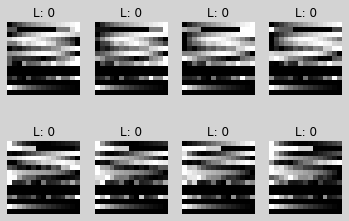

Percentage of class -1 = 21.306818181818183, class 0 = 73.29545454545455, class 1 = 5.3977272727272725


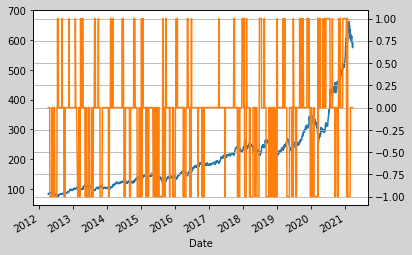

In [ ]:
#Filter the all the Nan data or select the date we need
datestamp = []
for i in range(len(StockTech.index)):
  datestamp.append(int(datetime.datetime.timestamp(StockTech.index[i])))
StockTech['datestamp'] = datestamp
# StockTech_Nonan = StockTech.loc[StockTech.datestamp>datetime.datetime.strptime('2020-01-01','%Y-%m-%d').timestamp()]
StockTech_Nonan = StockTech.iloc[60:len(StockTech),:]
StockTech_Nonan.to_csv('/content/drive/MyDrive/StockTech_Nonan.csv')
print(StockTech_Nonan)

#label the data and take out the Technical indicator and the label
ret = triple_barrier.triple_barrier(StockTech_Nonan, 1.1, 0.95, 20)
StockTechRet_Nonan = pd.concat([StockTech_Nonan,ret],axis=1)
StockTechRet_Nonan_TechInd = StockTechRet_Nonan.iloc[:len(StockTechRet_Nonan),6:15*15+6]


#Nomarlized (Min-Max Scaled)
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(-1,1))
# StockTechRet_Nonan_TechInd_Nom = scaler.fit_transform(StockTechRet_Nonan_TechInd)
StockTechRet_Nonan_TechInd_Nom = np.array(StockTechRet_Nonan_TechInd)


#change to pic size and input type
img_StockTechRet_Nonan_TechInd_Nom = []
for i in range(len(StockTechRet_Nonan_TechInd_Nom)):
  img_StockTechRet_Nonan_TechInd_Nom.append(np.transpose(scaler.fit_transform(StockTechRet_Nonan_TechInd_Nom[i].reshape((15,15)))).tolist())
StockTechRet_Nonan['img'] = img_StockTechRet_Nonan_TechInd_Nom
listData = []
listLabel = []
for i in range(len(StockTechRet_Nonan_TechInd_Nom)):
  listData.append(StockTechRet_Nonan.img.values[i])
  listLabel.append(StockTechRet_Nonan.triple_barrier_signal.values[i])
listData = np.array(listData).reshape(len(StockTechRet_Nonan_TechInd_Nom),15,15,1)
listLabel = np.array(listLabel).reshape(len(StockTechRet_Nonan_TechInd_Nom),1)
print("change to img type")

# train set and test set, 20天訓練，10天測試 
from sklearn.model_selection import train_test_split
# train_x, train_y, test_x, test_y  = [], [], [], []
# for i in range(int(np.floor((len(StockTechRet_Nonan)-30)/10))):
#   train_x.append(StockTechRet_Nonan.img[i*10:20+i*10])
#   train_y.append(StockTechRet_Nonan.triple_barrier_signal[i*10:20+i*10])
#   test_x.append(StockTechRet_Nonan.img[20+i*10:20+i*10+10])
#   test_y.append(StockTechRet_Nonan.triple_barrier_signal[20+i*10:20+i*10+10])
data_StockTechRet = StockTechRet_Nonan['img'].values
label_StockTechRet = StockTechRet_Nonan['triple_barrier_signal'].values
train_x, test_x, train_y, test_y = train_test_split(listData, listLabel, train_size=0.8, test_size=0.2, random_state=2, shuffle=False)
train_x, cv_x, train_y, cv_y = train_test_split(train_x, train_y, train_size=0.8, test_size=0.2, random_state=2, shuffle=False)

# output pic example
import matplotlib.pyplot as plt
picNumber = 8
images_labels = list(zip(StockTechRet_Nonan.img.values,StockTechRet_Nonan.triple_barrier_signal.values))
for i, (image, label) in enumerate(images_labels[0:8]):
  plt.figure('Img & Signal Diagram',facecolor = 'lightgray')
  plt.subplot(2,4,i+1)
  plt.axis('off')
  plt.imshow(image, cmap = 'gray')
  plt.title('L: '+ str(label))
plt.show()

# calculate the number of hold, buy and sell
_labels, _counts = np.unique(train_y, return_counts = True)
if np.size(_labels) == 3:
  print("Percentage of class -1 = {}, class 0 = {}, class 1 = {}".format(_counts[0]/len(train_y)*100, _counts[1]/len(train_y)*100, _counts[2]/len(train_y)*100))
else:
  print("Percentage of class -1 = {}, class 0 = {}, class 1 = {}".format(_counts[0]/len(train_y)*100, _counts[1]/len(train_y)*100, 0))

# plot the final data curve
import matplotlib.pyplot as mp
mp.figure('Stock Diagram',facecolor = 'lightgray')
StockTechRet_Nonan.close.plot()
StockTechRet_Nonan.triple_barrier_signal.plot(secondary_y=True)
mp.grid()

In [ ]:
from keras.models import Sequential  #用來啟動 NN
from keras.layers import Conv2D  # Convolution Operation
from keras.layers import MaxPooling2D # Pooling
from keras.layers import Flatten
from keras.layers import Dense # Fully Connected Networks
from keras.layers import Dropout
from keras.layers import LeakyReLU
from keras.layers import BatchNormalization
import tensorflow as tf
import tensorflow_addons as tfa



class Model():
  def __init__():
    pass

  # Build CNN
  def net():
    net = Sequential()
    net.add(Conv2D(32,(3,3), strides=(2,2), activation='relu', padding="same", use_bias=False,input_shape=(15,15,1)))
    net.add(Conv2D(64,(3,3), strides=(2,2), activation='relu', padding="same", use_bias=False))
    net.add(MaxPooling2D(2, strides=2))
    net.add(Dropout(0.25))
    net.add(Flatten())
    net.add(Dense(128,activation = None))
    net.add(Dropout(0.5))
    net.add(Dense(3,activation='softmax'))
    net.compile(loss="categorical_crossentropy", optimizer = "adam", metrics=["acc"])
    return net

  def net1(lr, total_step, warmup_proportion, min_lr):
    # Ranger optimizer 
    radam = tfa.optimizers.RectifiedAdam(lr=lr, total_steps=total_step, warmup_proportion=warmup_proportion, min_lr=min_lr)
    ranger = tfa.optimizers.Lookahead(radam, sync_period=6, slow_step_size=0.5)
    net1 = Sequential()
    net1.add(Conv2D(32,(3,3),strides=(2,2),activation=LeakyReLU(alpha=0.1),padding="same", use_bias=False,input_shape=(15,15,1)))
    net1.add(BatchNormalization())
    # net1.add(Dropout(0.25))
    net1.add(Conv2D(64,(3,3),strides=(2,2),activation=LeakyReLU(alpha=0.1),padding="same", use_bias=False))
    net1.add(BatchNormalization())
    net1.add(Dropout(0.25))
    net1.add(Conv2D(128,(3,3),strides=(2,2),activation=LeakyReLU(alpha=0.1),padding="same", use_bias=False))
    net1.add(BatchNormalization())
    # net1.add(Dropout(0.25))
    net1.add(MaxPooling2D(2,strides=2))
    net1.add(Dropout(0.25))
    net1.add(Flatten())
    net1.add(Dense(128,activation = None))
    net1.add(Dropout(0.5))
    net1.add(Dense(3,activation='softmax'))
    net1.compile(loss="categorical_crossentropy", optimizer = ranger, metrics=["acc"])
    return net1

Model: "sequential_217"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_450 (Conv2D)          (None, 8, 8, 32)          288       
_________________________________________________________________
conv2d_451 (Conv2D)          (None, 4, 4, 64)          18432     
_________________________________________________________________
max_pooling2d_217 (MaxPoolin (None, 2, 2, 64)          0         
_________________________________________________________________
dropout_450 (Dropout)        (None, 2, 2, 64)          0         
_________________________________________________________________
flatten_217 (Flatten)        (None, 256)               0         
_________________________________________________________________
dense_434 (Dense)            (None, 128)               32896     
_________________________________________________________________
dropout_451 (Dropout)        (None, 128)            

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

          -1       0.00      0.00      0.00        78
           0       0.53      0.68      0.59       240
           1       0.26      0.29      0.28       123

    accuracy                           0.45       441
   macro avg       0.27      0.32      0.29       441
weighted avg       0.36      0.45      0.40       441

The buying signal in these days: [0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1]
Buying price: [233.0, 249.0, 252.0, 272.0, 299.5, 311.0, 333.0, 315.0, 274.0, 304.5, 292.0, 313.0, 435.0, 434.5, 437.0, 452.0, 488.0, 510.0, 607.0]
Selling price: [233.0, 246.5, 280.0, 307.0, 345.0, 345.0, 315.0, 311.0, 306.5, 322.5, 322.5, 345.0, 458.0, 433.5, 432.0, 497.0, 565.0, 565.0, 673.0]
Cash: 1491.0
The buying signal in these days: [0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1]
Buying price: [233.0, 249.0, 260.0, 252.0, 272.0, 299.5, 311.0, 333.0, 315.0, 317.5, 274.0, 304.5, 292.0, 313.0, 435.0

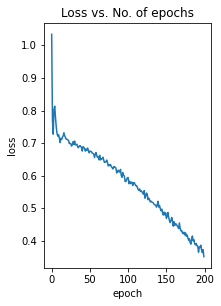

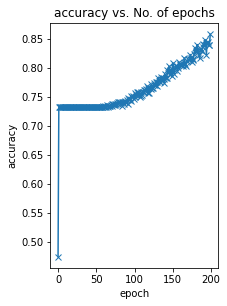

<Figure size 792x288 with 0 Axes>

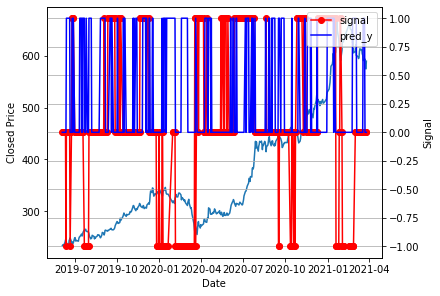

In [ ]:
# Postprocessing
# Print Model
print(Model.net().summary())

# Training progress
print("===============Training Process===============")
from keras import utils
ten_y=utils.to_categorical(train_y,3)
train_history = Model.net().fit(x=train_x,y=ten_y,batch_size=1028,epochs=200,shuffle=False)

# validation progress
print("===============Validation Process===============")
from keras import utils
list_cv_y=utils.to_categorical(cv_y,3)

list_cv_x=[]
for i in range(len(cv_x)):
  list_cv_x.append(cv_x[i].tolist())
list_cv_x=np.array(list_cv_x).reshape(len(list_cv_x),15,15,1)
validation_loss, validation_acc = Model.net().evaluate(list_cv_x,list_cv_y)
print("Validation Loss = {}, Validation Acc. = {}".format(validation_loss,validation_acc))

# Predict progress
print("===============Prediction Process===============")
list_test_y=utils.to_categorical(test_y,3)  # 0, 1, -1

list_test_x=[]
for i in range(len(test_x)):
  list_test_x.append(test_x[i].tolist())
list_test_x=np.array(list_test_x).reshape(len(test_x),15,15,1)

pre_y = Model.net().predict(list_test_x)
# As pre_y have 3 column therefore there will have 0,1,2 after calculate as np.argmax.
# Moreover, our label is 0, 1, -1. So we need to change the 2 to -1 when do the F1 score
pre_y_label=np.argmax(pre_y,axis=1)

# print("test y label:",np.reshape(test_y,(1,len(test_y))))
for i in range(len(pre_y_label)):
  if pre_y_label[i]==2:
    pre_y_label[i]=-1
# print("pred y label:",pre_y_label)

# print(pre_y)
# metric = tfa.metrics.F1Score(num_classes=3)
# metric.update_state(list_test_y, pre_y)
# result = metric.result()
# test_loss, test_acc = Model.net().evaluate(list_test_x,list_test_y)
# print("Test Loss = {}, Test Acc. = {}".format(test_loss,test_acc))
# print("F1Score --> 0: {}, 1: {}, -1: {}".format(result.numpy()[0],result.numpy()[1],result.numpy()[2]))

from sklearn.metrics import classification_report
print(classification_report(test_y, pre_y_label))


# losses = [x['loss'] for x in train_history.history]
losses = list(train_history.history['loss'])
accuracies = list(train_history.history['acc'])
plt.figure(facecolor='white',figsize=(3,4.5))
# plt.subplot(1,2,1)
plt.plot(losses)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs. No. of epochs');
# plt.subplot(1,2,2)
plt.figure(facecolor='white',figsize=(3,4.5))
plt.plot(accuracies, '-x')
plt.xlabel('epoch',)
plt.ylabel('accuracy')
plt.title('accuracy vs. No. of epochs');

# draw the signal and pred_y_label
plt.figure(facecolor='white',figsize=(11,4))
start = len(StockTechRet_Nonan)-len(test_x)
end = len(StockTechRet_Nonan)
price = StockTechRet_Nonan.close[start:end]
date = StockTechRet_Nonan.index[start:end]
signal = StockTechRet_Nonan.triple_barrier_signal[start:end]
predy = pre_y_label
fig, ax = plt.subplots(constrained_layout=True)
ax.plot(date,price,label='price')
ax1 = ax.twinx()
ax1.plot(date,signal,'r',marker = 'o',label = "signal")
ax1.plot(date,predy,'b',label = 'pred_y')
ax1.legend(loc = 1)
ax.set_xlabel('Date')
ax.set_ylabel('Closed Price')
ax1.set_ylabel('Signal')
# ax.xaxis.set_major_locator(mdates.MonthLocator(date))
mp.grid()

# Calculate the Financial Result
FinancialTesting(StockTechRet_Nonan[start:end],20,1000,1,20,1).process()
Pred_DataFrame = pd.DataFrame(StockTechRet_Nonan.index[start:end])
Pred_DataFrame = Pred_DataFrame.set_index('Date')
Pred_DataFrame['close'] = StockTechRet_Nonan.close[start:end]
Pred_DataFrame['triple_barrier_sell_time'] = StockTechRet_Nonan.triple_barrier_sell_time[start:end]
Pred_DataFrame['triple_barrier_signal'] = pre_y_label
FinancialTesting(Pred_DataFrame,20,1000,1,20,1).process()

# Plot the Confusion Matrix
# plot_confusion_matrix(ConfusionMatrix, normalize = False, target_names = ['stop loss', 'hold', 'stop profit'], title = "Confusion Matrix")

Model: "sequential_221"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_458 (Conv2D)          (None, 8, 8, 32)          288       
_________________________________________________________________
batch_normalization_48 (Batc (None, 8, 8, 32)          128       
_________________________________________________________________
conv2d_459 (Conv2D)          (None, 4, 4, 64)          18432     
_________________________________________________________________
batch_normalization_49 (Batc (None, 4, 4, 64)          256       
_________________________________________________________________
dropout_458 (Dropout)        (None, 4, 4, 64)          0         
_________________________________________________________________
conv2d_460 (Conv2D)          (None, 2, 2, 128)         73728     
_________________________________________________________________
batch_normalization_50 (Batc (None, 2, 2, 128)      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

          -1       0.18      0.99      0.30        78
           0       0.00      0.00      0.00       240
           1       0.43      0.02      0.05       123

    accuracy                           0.18       441
   macro avg       0.20      0.34      0.12       441
weighted avg       0.15      0.18      0.07       441

The buying signal in these days: [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0]
Buying price: [233.0, 235.5, 249.0, 256.0, 249.5, 252.0, 262.5, 272.0, 296.5, 299.5, 304.0, 311.0, 319.0, 333.0, 315.0, 274.0, 286.5, 304.5, 298.0, 292.0, 316.0, 313.0, 363.5, 435.0, 429.0, 434.5, 431.0, 437.0, 453.0, 452.0, 452.5, 488.0, 503.0, 510.0, 536.0, 607.0, 611.0]
Selling price: [233.0, 234.5, 246.5, 246.5, 280.0, 290.0, 290.0, 307.0, 345.0, 345.0, 345.0, 345.0, 315.0, 316.5, 311.0, 306.5, 322.5, 322.5, 322.5, 322.5, 348.5, 345.0, 424.5, 458.0, 433.5, 423.0, 43

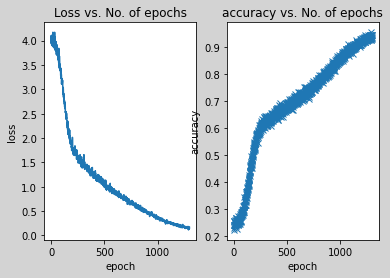

<Figure size 432x288 with 0 Axes>

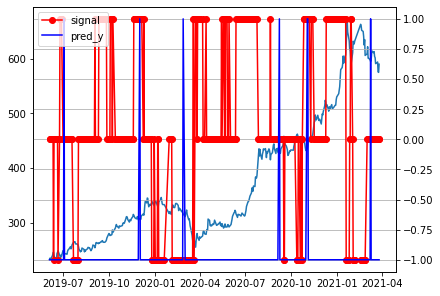

In [ ]:
from keras import utils
from sklearn.metrics import classification_report
# Model Summary
lr=1e-3
total_steps=10000
warmup_proportion=0.1
min_lr=1e-5
print(Model.net1(lr,total_steps,warmup_proportion,min_lr).summary())

# train
print("===============Training Process===============")
ten_y=utils.to_categorical(train_y,3)
train_history1 = Model.net1(lr,total_steps,warmup_proportion,min_lr).fit(x=train_x,y=ten_y,batch_size=2000,epochs=1300,shuffle=False)

# validation
print("===============Validation Process===============")
list_cv_y=utils.to_categorical(cv_y,3)
list_cv_x=[]
for i in range(len(cv_x)):
  list_cv_x.append(cv_x[i].tolist())
list_cv_x=np.array(list_cv_x).reshape(len(list_cv_x),15,15,1)
validation_loss1, validation_acc1 = Model.net1(lr,total_steps,warmup_proportion,min_lr).evaluate(list_cv_x,list_cv_y)
print("Validation Loss = {}, Validation Acc. = {}".format(validation_loss1,validation_acc1))

# predict
print("===============Prediction Process===============")
list_test_y=utils.to_categorical(test_y,3)  # 0, 1, -1

list_test_x=[]
for i in range(len(test_x)):
  list_test_x.append(test_x[i].tolist())
list_test_x=np.array(list_test_x).reshape(len(test_x),15,15,1)
pre_y1 = Model.net1(lr,total_steps,warmup_proportion,min_lr).predict(list_test_x)
pre_y_label1=np.argmax(pre_y1,axis=1)
# change the label from 2 into -1
for i in range(len(pre_y_label1)):
  if pre_y_label1[i]==2:
    pre_y_label1[i]=-1
print(classification_report(test_y, pre_y_label1))

losses1 = list(train_history1.history['loss'])
accuracies1 = list(train_history1.history['acc'])
plt.figure(facecolor='lightgray')
plt.subplot(1,2,1)
plt.plot(losses1)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs. No. of epochs');
plt.subplot(1,2,2)
plt.plot(accuracies1, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('accuracy vs. No. of epochs');

# draw the signal and pred_y_label
plt.figure(facecolor='lightgray')
start = len(StockTechRet_Nonan)-len(test_x)
end = len(StockTechRet_Nonan)
price = StockTechRet_Nonan.close[start:end]
date = StockTechRet_Nonan.index[start:end]
signal = StockTechRet_Nonan.triple_barrier_signal[start:end]
predy = pre_y_label1
fig, ax = plt.subplots(constrained_layout=True)
ax.plot(date,price)
ax1 = ax.twinx()
ax1.plot(date,signal,'r',marker = 'o',label = "signal")
ax1.plot(date,predy,'b',label = 'pred_y')
ax1.legend()
mp.grid()

# Calculate the Financial Result
FinancialTesting(StockTechRet_Nonan[start:end],10,1000,1,20,1).process()
Pred_DataFrame = pd.DataFrame(StockTechRet_Nonan.index[start:end])
Pred_DataFrame = Pred_DataFrame.set_index('Date')
Pred_DataFrame['close'] = StockTechRet_Nonan.close[start:end]
Pred_DataFrame['triple_barrier_sell_time'] = StockTechRet_Nonan.triple_barrier_sell_time[start:end]
Pred_DataFrame['triple_barrier_signal'] = pre_y_label1
FinancialTesting(Pred_DataFrame,10,1000,1,20,1).process()

# Plot the Confusion Matrix
# plot_confusion_matrix(ConfusionMatrix1, normalize = False, target_names = ['stop loss', 'hold', 'stop profit'], title = "Confusion Matrix")

In [ ]:
# Calculate the Financial Result
FinancialTesting(StockTechRet_Nonan[start:end],10,1000,1,20,1).process()
FinancialTesting(Pred_DataFrame,10,1000,1,20,1).process()

The buying signal in these days: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Buying price: [39.8, 39.55, 38.6, 38.4, 38.65, 40.95, 40.4, 41.8, 41.3, 40.5, 42.2]
Selling price: [38.0, 38.0, 40.1, 39.9, 39.9, 40.65, 40.1, 40.1, 40.1, 44.3, 46.7]
Cash: 1005.0
The buying signal in these days: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Buying price: [39.8, 39.55, 40.2, 38.6, 38.4, 38.65, 40.95, 40.4, 41.3, 42.3, 40.5, 42.2]
Selling price: [40.2, 38.7, 38.0, 38.4, 40.55, 41.35, 41.95, 41.15, 41.0, 40.1, 42.35, 46.7]
Cash: 1007.0
